In this notebook, we will analyze stock data sourced from Alpha Vantage. Our workflow will include:

   1. Feature Engineering – Creating meaningful features from raw stock data to enhance our analysis and modeling.

   2. Data Visualization – Exploring trends, patterns, and relationships in the data through visualizations.

   3. Predictive Modeling – Building a model to forecast stock behavior using the engineered features.

By the end of this notebook, we aim to uncover insights from historical stock data and demonstrate a predictive approach that can inform trading or investment decisions.

Load and inspect dynamic daily stock data. Ensure dates are in ascending order for time‐series modeling.

In [3]:
# Connect to AlphaVantage and collect stock data
import requests
from dotenv import load_dotenv
from os import getenv

load_dotenv()
API_KEY = getenv("ALPHAVANTAGE_API_KEY")

symbol = "SPY"
url = (f"https://www.alphavantage.co/query"
        + "?function=TIME_SERIES_DAILY"
        + f"&symbol={symbol}"
        + f"&apikey={API_KEY}"
        #+ "&outputsize=full"
      )
r = requests.get(url)
data = r.json()


In [4]:
# Print relevant metadata
print("DATA:         ", data.get("Meta Data").get("1. Information"))
print("SYMBOL:       ", data.get("Meta Data").get("2. Symbol"))
print("REFRESH DATE: ", data.get("Meta Data").get("3. Last Refreshed"))

DATA:          Daily Prices (open, high, low, close) and Volumes
SYMBOL:        SPY
REFRESH DATE:  2025-11-07


In [5]:
# Load data into a pandas DataFrame
import pandas as pd

df = pd.DataFrame.from_dict(data.get("Time Series (Daily)"), orient='index')
df.index.name = 'date'
df.reset_index(inplace=True)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

print(df)

          date      open      high       low     close     volume
0   2025-11-07  667.9100  671.0800  661.2050  670.9700  100592443
1   2025-11-06  676.4700  677.3800  668.7200  670.3100   85035298
2   2025-11-05  674.9800  680.8600  674.1700  677.5800   72763485
3   2025-11-04  676.1100  679.9600  674.5800  675.2400   78426969
4   2025-11-03  685.6700  685.8000  679.9400  683.3400   57315025
..         ...       ...       ...       ...       ...        ...
95  2025-06-25  607.9100  608.6100  605.5400  607.1200   62114767
96  2025-06-24  604.3300  607.8499  603.4100  606.7800   67735293
97  2025-06-23  595.0400  600.5400  591.8900  600.1500   87426039
98  2025-06-20  598.3800  599.4600  592.8600  594.2800   94051374
99  2025-06-18  598.4400  601.2200  596.4700  597.4400   76605029

[100 rows x 6 columns]


In [6]:
# Convert columns to float
df['open'] = df['open'].astype(float)
df['close'] = df['close'].astype(float)
df['volume'] = df['volume'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)

In [7]:
import numpy as np

# Sort by date just in case
df = df.sort_values('date')

df["day's range"] = df['close'] - df['open']
df['price difference'] = df['high'] - df['low']
df['day to day'] = df['close'] - df['open'].shift(1)
df['log returns'] = np.log(df['close'] / df['close'].shift(1))                       

In [8]:
# Overall range
overall_range = df['close'].max() - df['open'].min()
print("Overall Open-to-Close Range:", overall_range)

Overall Open-to-Close Range: 92.35000000000002


In [9]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns
99,2025-06-18,598.44,601.22,596.47,597.44,76605029.0,-1.0,4.75,NaN,NaN
98,2025-06-20,598.38,599.46,592.86,594.28,94051374.0,-4.1,6.60,-4.16,-0.005303


In [10]:
# Day-to-day volume change
df['volume_change'] = df['volume'] - df['volume'].shift(1)

# Optional: percentage change
df['volume_pct_change'] = df['volume'].pct_change() * 100

# Calculate Price / Volume for each row (using Close price)
df['price by volume'] = df['close'] / df['volume']

In [11]:
# Initialize OBV
df['obv'] = 0

# Loop method with .loc
for i in range(1, len(df)):
    if df['close'].iloc[i] > df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] + df.loc[i, 'volume']
    elif df['close'].iloc[i] < df['close'].iloc[i-1]:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv'] - df.loc[i, 'volume']
    else:
        df.loc[i, 'obv'] = df.loc[i-1, 'obv']

# 7-day moving average of volume
df['volume_ma7'] = df['volume'].rolling(window=7).mean()

In [12]:
df.head(2)

,date,open,high,low,close,volume,day's range,price difference,day to day,log returns,volume_change,volume_pct_change,price by volume,obv,volume_ma7
99,2025-06-18,598.44,601.22,596.47,597.44,76605029.0,-1.0,4.75,NaN,NaN,NaN,NaN,0.000008,1237799252,NaN
98,2025-06-20,598.38,599.46,592.86,594.28,94051374.0,-4.1,6.60,-4.16,-0.005303,17446345.0,22.774412,0.000006,1161194223,NaN


In [13]:
# Create lag features for close and volume
lag_days = [1, 2, 3]  # 1-day, 2-day, 3-day lags

for lag in lag_days:
    df[f'close_lag_{lag}'] = df['close'].shift(lag)
    df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
    df[f'price_by_volume_lag_{lag}'] = (df['close'] * df['volume']).shift(lag)

# View result
print(df[['date', 'close', 'close_lag_1', 'close_lag_2', 'close_lag_3',
          'volume', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3']])

          date   close  close_lag_1  close_lag_2  close_lag_3       volume  \
99  2025-06-18  597.44          NaN          NaN          NaN   76605029.0   
98  2025-06-20  594.28       597.44          NaN          NaN   94051374.0   
97  2025-06-23  600.15       594.28       597.44          NaN   87426039.0   
96  2025-06-24  606.78       600.15       594.28       597.44   67735293.0   
95  2025-06-25  607.12       606.78       600.15       594.28   62114767.0   
..         ...     ...          ...          ...          ...          ...   
4   2025-11-03  683.34       682.06       679.83       687.39   57315025.0   
3   2025-11-04  675.24       683.34       682.06       679.83   78426969.0   
2   2025-11-05  677.58       675.24       683.34       682.06   72763485.0   
1   2025-11-06  670.31       677.58       675.24       683.34   85035298.0   
0   2025-11-07  670.97       670.31       677.58       675.24  100592443.0   

    volume_lag_1  volume_lag_2  volume_lag_3  
99           NaN

                      close    volume  price by volume  log returns  \
close              1.000000  0.021709         0.120822    -0.016762   
volume             0.021709  1.000000        -0.924880    -0.433029   
price by volume    0.120822 -0.924880         1.000000     0.290250   
log returns       -0.016762 -0.433029         0.290250     1.000000   
day to day        -0.043750 -0.561245         0.422048     0.737848   
volume_change     -0.027874  0.622147        -0.559963    -0.588397   
volume_pct_change -0.009651  0.667936        -0.619532    -0.555638   
obv               -0.835386 -0.121290        -0.018251     0.140345   
open               0.987289  0.091153         0.070979    -0.148996   
high               0.993136  0.093584         0.064995    -0.104650   
low                0.996029  0.002601         0.146087    -0.058565   

                   day to day  volume_change  volume_pct_change       obv  \
close               -0.043750      -0.027874          -0.009651 -0.835

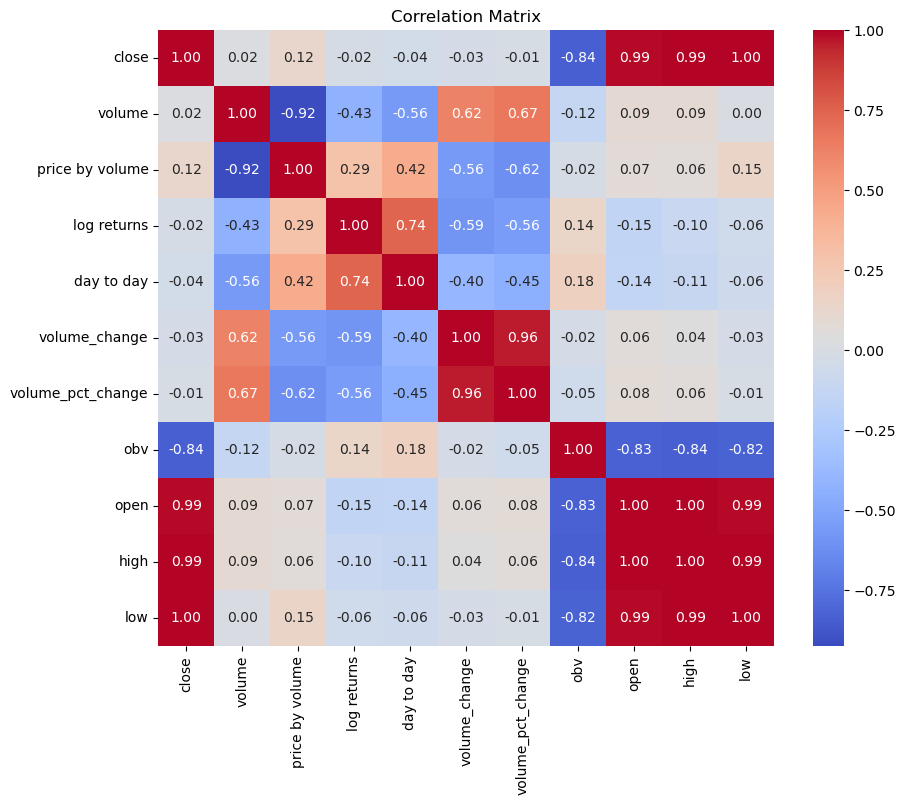

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns you want to check correlations for
numeric_cols = ['close', 'volume', 'price by volume', 'log returns', 
                'day to day', 'volume_change', 'volume_pct_change', 'obv',
                'open', 'high', 'low']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display correlation matrix
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

### Correlation Matrix

This matrix highlights relationships between price, volume, and derived indicators over the 5-month period.

- **Close, Open, High, and Low** show near-perfect positive correlations (~0.99–1.00), which is expected since they move together within daily trading ranges.  
- **Price by Volume** is **strongly negatively correlated (-0.92)** with **Volume**, suggesting that higher traded volumes tend to occur when prices are lower, possibly reflecting sell-offs or accumulation periods.  
- **OBV (On-Balance Volume)** has a **strong negative correlation (~-0.75)** with **Close and Price metrics**, reinforcing the observation that rising volumes have accompanied price declines.  
- **Volume Change** and **Volume % Change** are **strongly positively correlated (~0.96)**, which confirms internal consistency between absolute and relative measures of volume volatility.  
- **Log Returns** have weak correlations with most other metrics, implying that short-term returns are not directly explained by raw volume or price levels.

Overall, the heatmap suggests a bearish environment where higher trading activity is generally associated with price decreases.

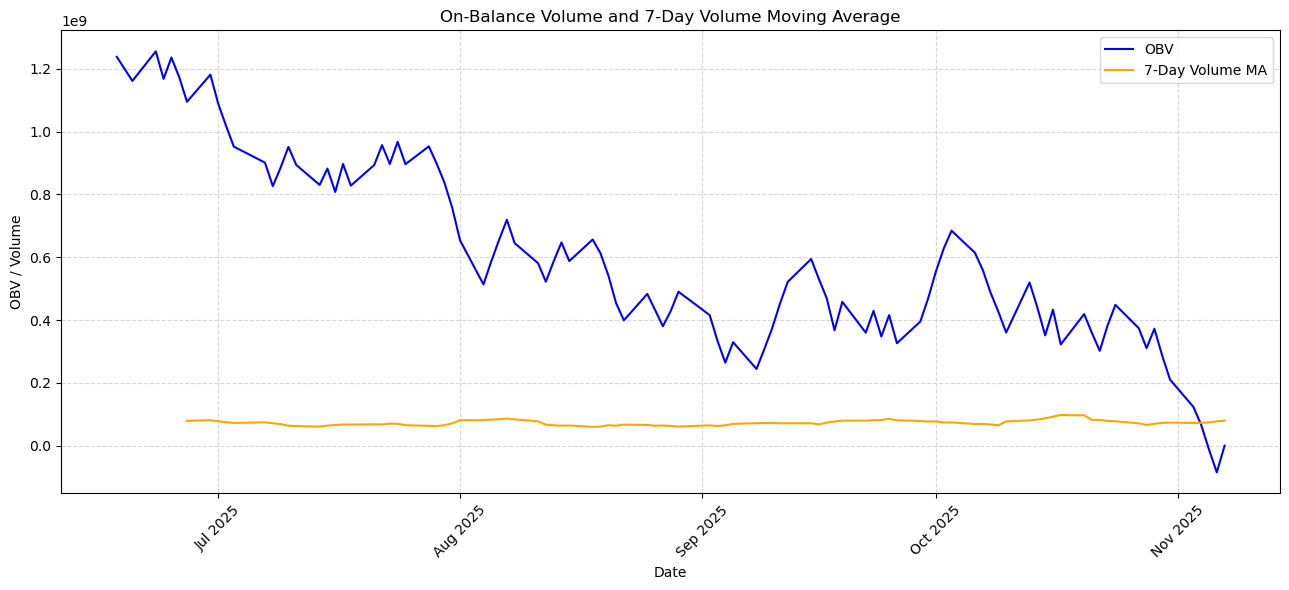

In [16]:
import matplotlib.dates as mdates
plt.figure(figsize=(13,6))

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# OBV line
plt.plot(df['date'], df['obv'], color='blue', label='OBV')

# Format x-axis to show months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())       # one tick per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2025", etc.

# Volume moving average line
plt.plot(df['date'], df['volume_ma7'], color='orange', label='7-Day Volume MA')

plt.xlabel('Date')
plt.ylabel('OBV / Volume')
plt.title('On-Balance Volume and 7-Day Volume Moving Average')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### On-Balance Volume (OBV) and 7-Day Volume Moving Average

This visualization compares **On-Balance Volume (OBV)**, which measures buying and selling pressure, against a **7-day moving average of trading volume**.

- **OBV Trend:** The OBV line declines steadily throughout most of the 5-month window, with a brief spike in September before dropping sharply again into late October. This pattern indicates that selling pressure has consistently outweighed buying pressure, aligning with bearish market sentiment.  
- **7-Day Volume MA:** The orange line remains nearly flat, showing that overall trading volume has been stable even as OBV declines. This suggests the downward momentum in OBV is not due to a surge in volume, but rather that more of the existing trading activity is occurring on down days than up days.  
- **Interpretation:** The divergence between a falling OBV and flat average volume implies persistent distribution (selling into demand) and limited new inflows of bullish volume. In other words, traders are active but not strongly accumulating the asset.

Overall, this graph confirms that despite consistent trading volume, downward price pressure has dominated, reinforcing the weak sentiment seen in the correlation matrix.

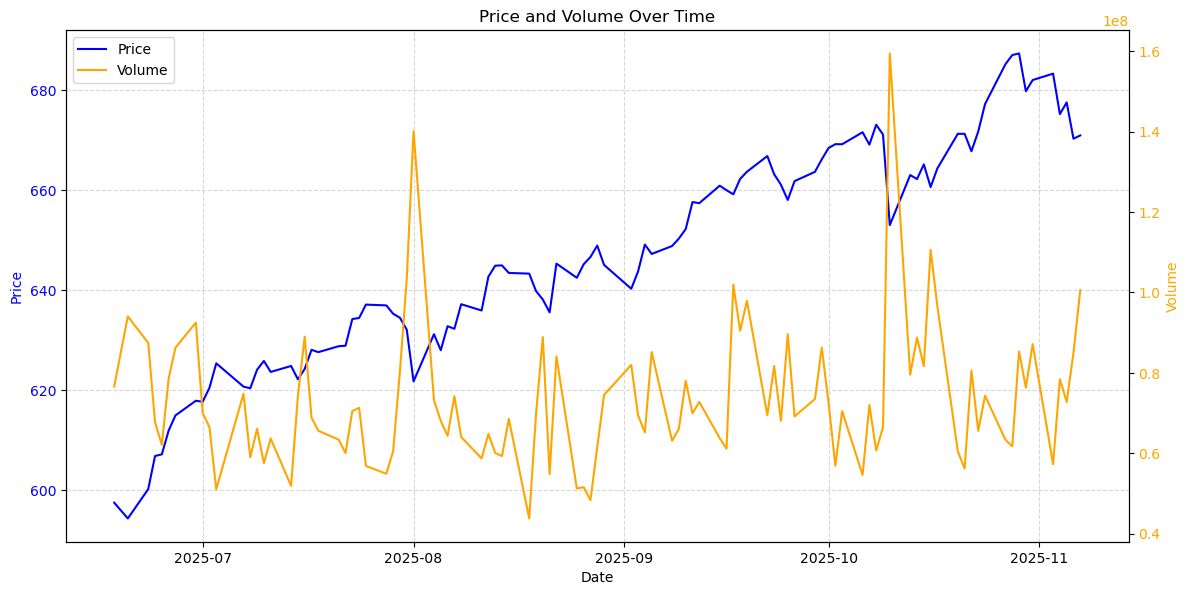

In [18]:
df['date'] = pd.to_datetime(df['date'])

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot price on left Y-axis
ax1.plot(df['date'], df['close'], color='blue', label='Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Create second Y-axis for volume
ax2 = ax1.twinx()
ax2.plot(df['date'], df['volume'], color='orange', label='Volume')
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
fig.tight_layout()
plt.title('Price and Volume Over Time')

# Show combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

### Price and Volume Over Time

This chart compares the stock’s **daily closing price** (blue line, left axis) with its **trading volume** (orange line, right axis) across a five-month period.

- **Price Movement:** The price shows a clear upward trend from around 595 in early June to roughly 680 by late October, indicating a steady period of appreciation with short pullbacks along the way.  
- **Volume Activity:** Volume is highly volatile but without a consistent trend. There are noticeable spikes in early August and early October, which may correspond to significant market events or earnings announcements.  
- **Interpretation:** The price’s rise despite fluctuating volume suggests sustained investor confidence even when trading activity temporarily declined. The major volume spikes likely indicate strong buying or selling reactions during those periods, but since price continued to rise, they likely reflect **buying pressure on high-volume days** rather than distribution.

Overall, this visualization highlights a **bullish price trend** supported by intermittent bursts of heavy trading, reflecting investor optimism through the latter part of the period.

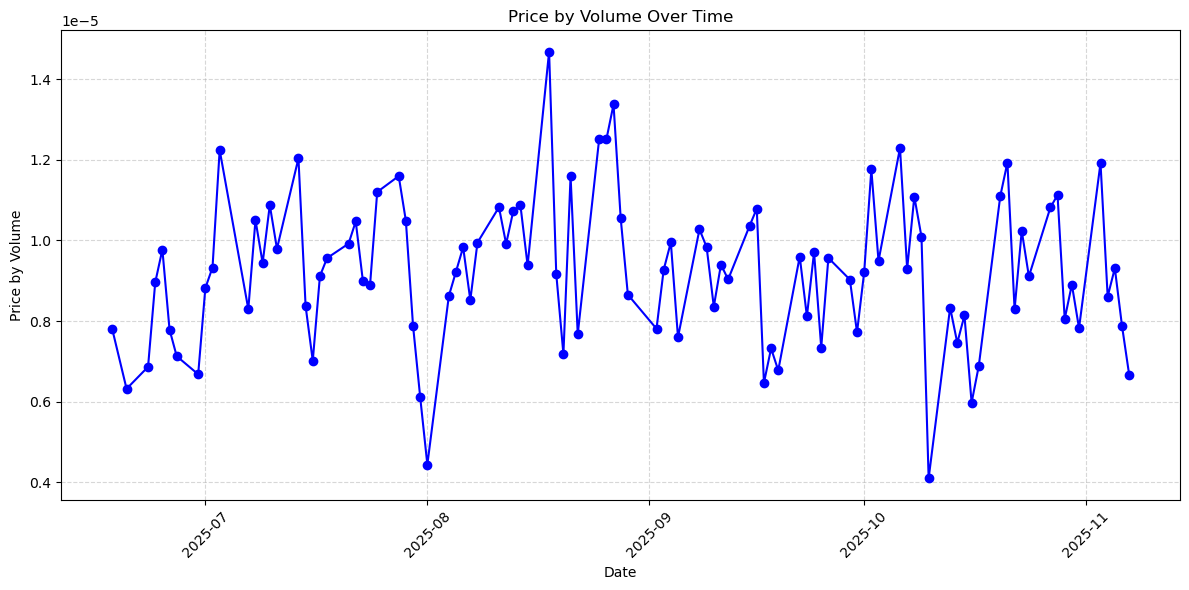

In [20]:
# Plot line graph
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Price by Volume')
plt.title('Price by Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Price by Volume Over Time

This visualization shows the ratio of **price divided by trading volume** across the observed period, offering insight into how much price movement occurred per unit of trading activity.

- **Trend Overview:** The ratio remains mostly low throughout the period, with a **notable spike in late August**, suggesting a temporary surge in price relative to trading volume.  
- **August Spike:** The late August increase implies that prices rose while trading volume stayed relatively low, meaning **price gains were not broadly supported by trading activity**.  
- **Subsequent Decline:** After the spike, the ratio steadily declines through September and October, indicating that **either prices dropped or trading volume rose**, signaling heavier trading relative to price movement.  
- **Interpretation:** Sustained low values of price/volume often suggest **high liquidity or strong trading activity**, while higher values indicate **price sensitivity under lower trading volume**.  
- **Overall:** The chart reflects that, for most of the period, the stock’s price changes were backed by consistent trading volume. The short-lived August spike could represent a **temporary imbalance**, where prices moved quickly without equivalent trading depth.

This pattern suggests the market generally remained active and liquid, with only brief moments of divergence between price action and trading participation.

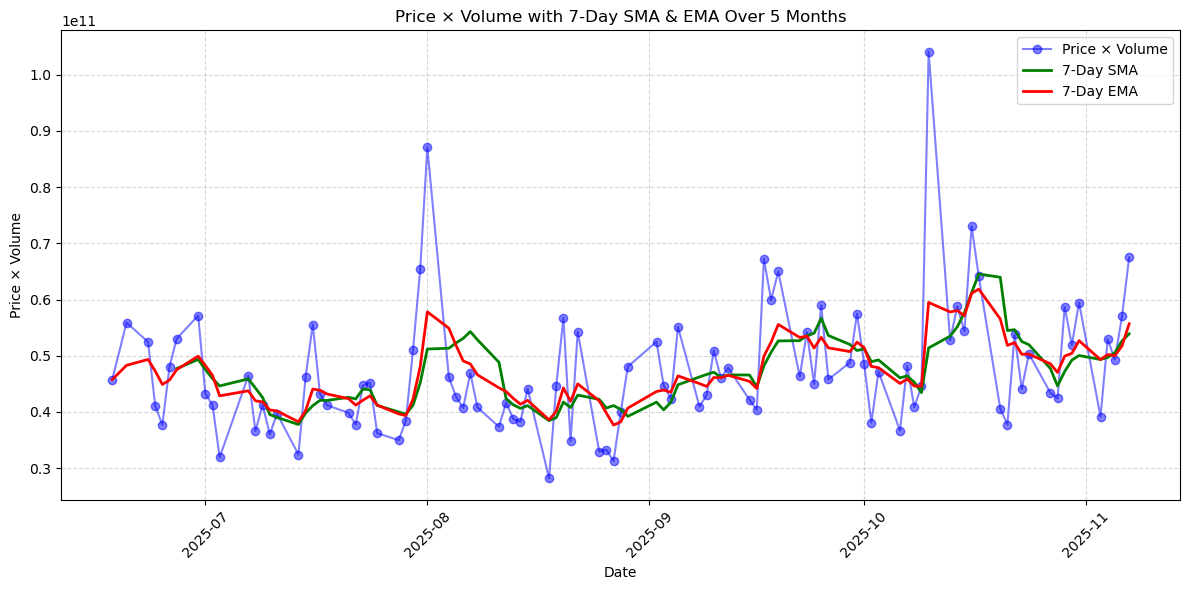

In [22]:
# Calculate Price × Volume
df['price by volume'] = df['close'] * df['volume']

# Calculate 7-day SMA
df['sma7'] = df['price by volume'].rolling(window=7).mean()

# Calculate 7-day EMA
df['ema7'] = df['price by volume'].ewm(span=7, adjust=False).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], marker='o', linestyle='-', alpha=0.5, label='Price × Volume', color='blue')
plt.plot(df['date'], df['sma7'], color='green', linewidth=2, label='7-Day SMA')
plt.plot(df['date'], df['ema7'], color='red', linewidth=2, label='7-Day EMA')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with 7-Day SMA & EMA Over 5 Months')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Price × Volume with 7-Day SMA & EMA (May–October 2025)

This chart illustrates **Price × Volume** over time, along with its **7-day Simple Moving Average (SMA)** and **7-day Exponential Moving Average (EMA)** to smooth out short-term fluctuations and highlight underlying momentum.

- **Trend Overview:** Overall, the Price × Volume metric remains fairly stable between 0.3e11 and 0.6e11 for most of the period, with two major spikes—one in early August and another in early October.  
- **Spikes:** The two large peaks indicate **periods of intense trading activity combined with higher prices**, suggesting possible short-term investor reactions or external market catalysts.  
- **Averages:**  
  - The **7-day SMA (green)** provides a broader trend line, showing modest fluctuations around 0.4e11 to 0.5e11.  
  - The **7-day EMA (red)** responds faster to recent changes and captures short-term increases before and after the major spikes, indicating **brief surges in trading momentum**.  
- **Late Period Decline:** After the October spike, both moving averages taper off, signaling a return to **lower overall market activity** and **reduced buying pressure**.  

**Interpretation:**  
Price × Volume is a proxy for **market strength**, as it combines both price level and participation. The pattern suggests that while the market experienced a few bursts of high engagement, the general activity level remained consistent, with no sustained upward trend in momentum.


### Price × Volume with 7-Day SMA & EMA Over 5 Months
This chart overlays short-term and smoothed trend indicators (SMA and EMA) on the price × volume data.  
The SMA captures the general upward trend through July, while the EMA responds faster to daily changes, capturing short-term accelerations or slowdowns.  
When the EMA moves above the SMA (June–July), it indicates strong bullish momentum supported by volume; when it dips below (September), it signals trend exhaustion or short-term correction.  
The alignment of both near October reflects market consolidation and reduced volatility.

Bullish SMA crossovers:
          date          sma7         sma30
70 2025-07-31  4.514351e+10  4.399792e+10
45 2025-09-05  4.484316e+10  4.431543e+10
20 2025-10-10  5.138942e+10  5.036063e+10
1  2025-11-06  5.263563e+10  5.147271e+10
Bearish SMA crossovers:
          date          sma7         sma30
62 2025-08-12  4.234517e+10  4.374212e+10
24 2025-10-06  4.606819e+10  4.701435e+10
10 2025-10-24  5.196492e+10  5.230126e+10
Bullish EMA crossovers:
          date          ema7         ema30
98 2025-06-20  4.829839e+10  4.642020e+10
93 2025-06-27  4.752153e+10  4.647257e+10
70 2025-07-31  4.804276e+10  4.427777e+10
56 2025-08-20  4.425774e+10  4.425350e+10
54 2025-08-22  4.499088e+10  4.433043e+10
48 2025-09-02  4.364099e+10  4.307086e+10
20 2025-10-10  5.948557e+10  5.059340e+10
5  2025-10-31  5.268612e+10  5.143945e+10
1  2025-11-06  5.174238e+10  5.110667e+10
Bearish EMA crossovers:
          date          ema7         ema30
95 2025-06-25  4.488841e+10  4.587875e+10
90 2025-07-02  4.6

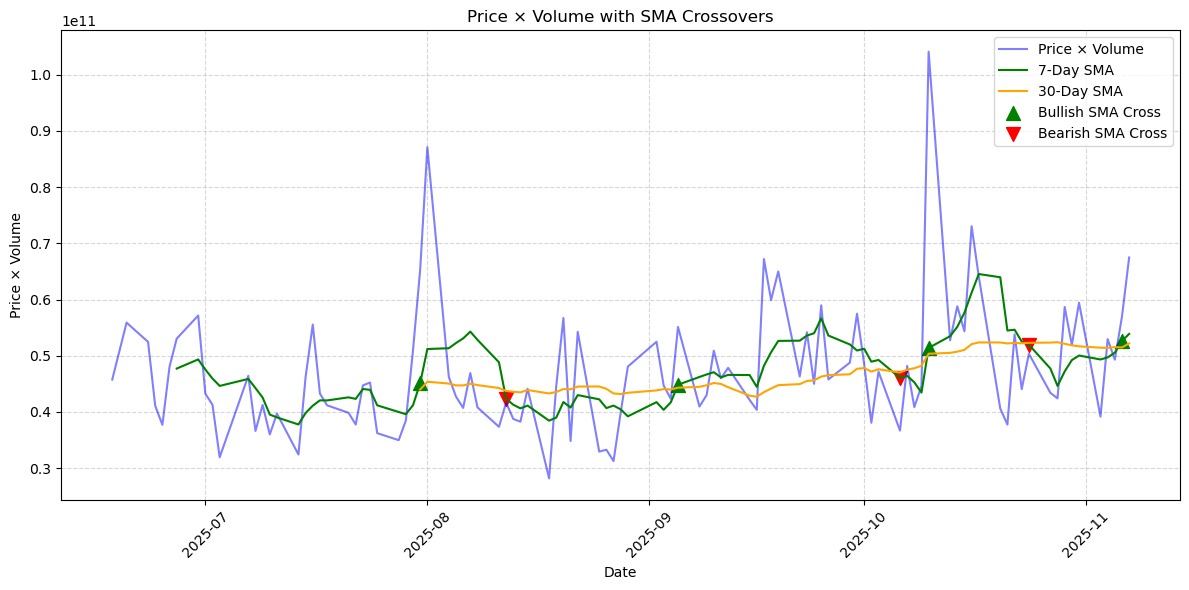

In [25]:
# Short-term and long-term SMAs
df['sma30'] = df['price by volume'].rolling(window=30).mean()

# Short-term and long-term EMAs
df['ema30'] = df['price by volume'].ewm(span=30, adjust=False).mean()

# Find crossover signals (SMA example)
df['sma_signal'] = np.where(df['sma7'] > df['sma30'], 1, 0)  # 1 = bullish, 0 = bearish
df['sma_crossover'] = df['sma_signal'].diff()  # 1 = buy, -1 = sell

# Find crossover signals (EMA example)
df['ema_signal'] = np.where(df['ema7'] > df['ema30'], 1, 0)
df['ema_crossover'] = df['ema_signal'].diff()

# Print crossover points
bullish_sma = df[df['sma_crossover'] == 1]
bearish_sma = df[df['sma_crossover'] == -1]

bullish_ema = df[df['ema_crossover'] == 1]
bearish_ema = df[df['ema_crossover'] == -1]

print("Bullish SMA crossovers:\n", bullish_sma[['date', 'sma7', 'sma30']])
print("Bearish SMA crossovers:\n", bearish_sma[['date', 'sma7', 'sma30']])
print("Bullish EMA crossovers:\n", bullish_ema[['date', 'ema7', 'ema30']])
print("Bearish EMA crossovers:\n", bearish_ema[['date', 'ema7', 'ema30']])

# Optional: plot SMA crossovers
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['price by volume'], color='blue', alpha=0.5, label='Price × Volume')
plt.plot(df['date'], df['sma7'], color='green', label='7-Day SMA')
plt.plot(df['date'], df['sma30'], color='orange', label='30-Day SMA')

# Mark bullish and bearish crossovers
plt.scatter(bullish_sma['date'], bullish_sma['sma7'], marker='^', color='g', s=100, label='Bullish SMA Cross')
plt.scatter(bearish_sma['date'], bearish_sma['sma7'], marker='v', color='r', s=100, label='Bearish SMA Cross')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Price × Volume with SMA Crossovers')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Price × Volume with SMA Crossovers (May–October 2025)

This chart shows **Price × Volume** over five months, along with two trend indicators — the **7-day Simple Moving Average (SMA)** and the **30-day SMA** — to highlight short- and long-term shifts in trading momentum.  

- **Trend Overview:** The Price × Volume values fluctuate between roughly 0.3e11 and 0.9e11, with brief spikes in early August and early October.  
- **Moving Averages:**  
  - The **7-day SMA (green)** reacts quickly to short-term changes, capturing faster fluctuations.  
  - The **30-day SMA (orange)** moves more gradually, showing the broader market trend hovering near 0.45e11.  
- **Crossover Points:**  
  - **Bullish Crossovers (green triangles)** occur when the 7-day SMA rises above the 30-day SMA, signaling potential upward momentum. These appear around early September and early October, aligning with short bursts of increased trading activity.  
  - **Bearish Crossovers (red triangles)** happen when the 7-day SMA drops below the 30-day SMA, marking a slowdown in momentum. These appear shortly after each spike, reflecting quick reversals.  
- **Interpretation:**  
  The pattern suggests a **volatile but balanced market**, with short-term enthusiasm followed by quick corrections. SMA crossovers effectively capture these momentum swings, showing how investor activity accelerates briefly before returning to steady levels.

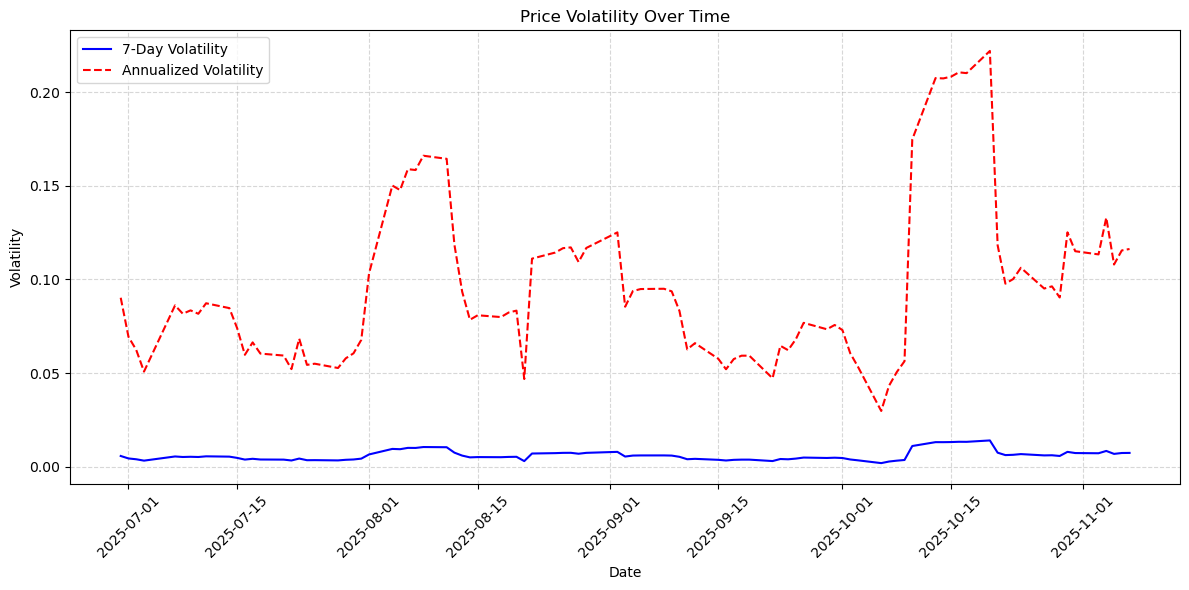

In [27]:
# Calculate daily returns
df['returns'] = df['close'].pct_change()

# Calculate rolling volatility (e.g., 7-day)
df['volatility_7d'] = df['returns'].rolling(window=7).std()

# Optional: annualized volatility (assuming 252 trading days)
df['volatility_annualized'] = df['volatility_7d'] * np.sqrt(252)

# Plot rolling volatility
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['volatility_7d'], label='7-Day Volatility', color='blue')
plt.plot(df['date'], df['volatility_annualized'], label='Annualized Volatility', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Price Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Price Volatility Over Time (May–November 2025)

This visualization tracks short-term and annualized price volatility to assess how consistently or erratically the stock moved over the 5-month period.

- **7-Day Volatility (blue line):**  
  The short-term volatility remains very low throughout the period, fluctuating slightly around 0.01. This indicates that day-to-day price changes were relatively small and stable. Only a few brief upticks appear, suggesting short-lived bursts of trading activity but no sustained turbulence.

- **Annualized Volatility (red dashed line):**  
  The annualized volatility varies more widely, ranging from roughly 0.05 to 0.20. Peaks occur around early August and mid-October, suggesting two periods when price movement was more erratic. These spikes likely correspond to either external market events or shifts in trading volume during those weeks.

- **Interpretation:**  
  Overall, the stock showed **low short-term volatility** with **intermittent high annualized volatility**, implying that while day-to-day movements were calm, there were isolated stretches of intensified activity that briefly raised long-term risk estimates. The pattern reflects a generally stable stock punctuated by short-lived market reactions or speculative trading phases.

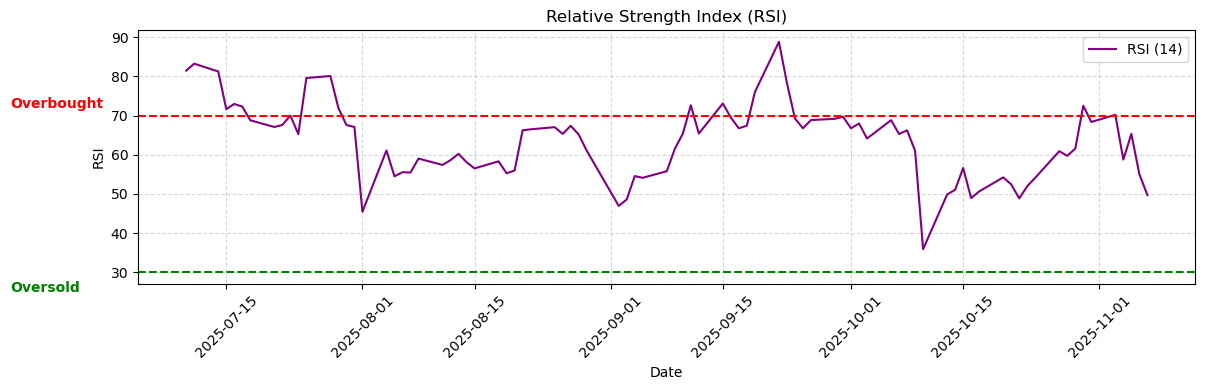

In [29]:
# Calculate daily returns
delta = df['close'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Calculate average gain/loss
window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['rsi'], color='purple', label='RSI (14)')
plt.axhline(70, color='red', linestyle='--')  # overbought
plt.axhline(30, color='green', linestyle='--')  # oversold
plt.text(df['date'].iloc[0], 70+2, 'Overbought', color='red', fontsize=10, fontweight='bold')
plt.text(df['date'].iloc[0], 30-5, 'Oversold', color='green', fontsize=10, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index (RSI)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Relative Strength Index (RSI)

This chart shows the 14-day Relative Strength Index (RSI), which helps identify whether the stock is overbought or oversold during the observed period.

- **Overbought Region (RSI > 70):**  
  The stock entered overbought territory several times, notably in mid-July, late September, and early November. These peaks suggest strong bullish momentum, but they also signal potential price corrections as traders may begin to take profits.

- **Oversold Region (RSI < 30):**  
  RSI briefly dipped below 30 around early August and mid-October. These moments indicate overselling pressure, often preceding short-term rebounds as the price becomes temporarily undervalued.

- **Interpretation:**  
  The RSI fluctuated frequently between 40 and 75, reflecting alternating bullish and bearish momentum. However, since it never stayed oversold or overbought for long, the stock showed **mean-reverting behavior** with no extreme, sustained momentum in either direction.

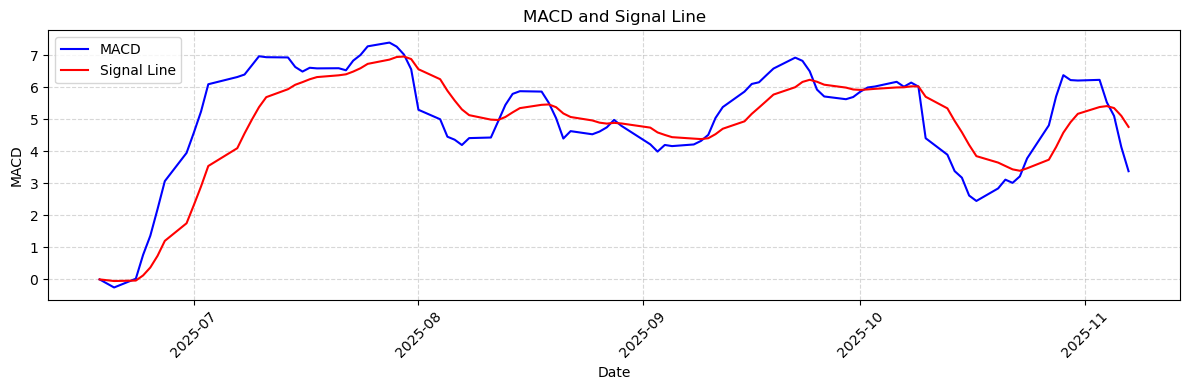

In [31]:
# Calculate MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Signal line
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Plot MACD
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['macd'], label='MACD', color='blue')
plt.plot(df['date'], df['macd_signal'], label='Signal Line', color='red')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('MACD and Signal Line')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### MACD and Signal Line

The Moving Average Convergence Divergence (MACD) indicator shows momentum by tracking the relationship between two moving averages of price. The **blue line** represents the MACD, and the **red line** represents the signal line.

- **Bullish Crossovers (MACD > Signal Line):**  
  The MACD crossed above the signal line several times, such as in early July, late August, and mid-October. These moments typically indicate upward momentum and potential buying opportunities.

- **Bearish Crossovers (MACD < Signal Line):**  
  When the MACD line dropped below the signal line, such as in late July and early October, it suggested weakening momentum or possible price corrections.

- **Interpretation:**  
  Overall, the MACD fluctuated frequently but remained mostly above the signal line for much of the observed period. This suggests that despite short-term pullbacks, the general trend remained **moderately bullish** with recurring cycles of momentum gain and loss.

In [33]:
# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Create day of week column (0=Monday, 6=Sunday)
df['day_of_week'] = df['date'].dt.dayofweek

# Create day-of-week one-hot
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='dow')], axis=1)

# Check which columns exist
print(df.filter(like='dow_').columns)

Index(['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4'], dtype='object')


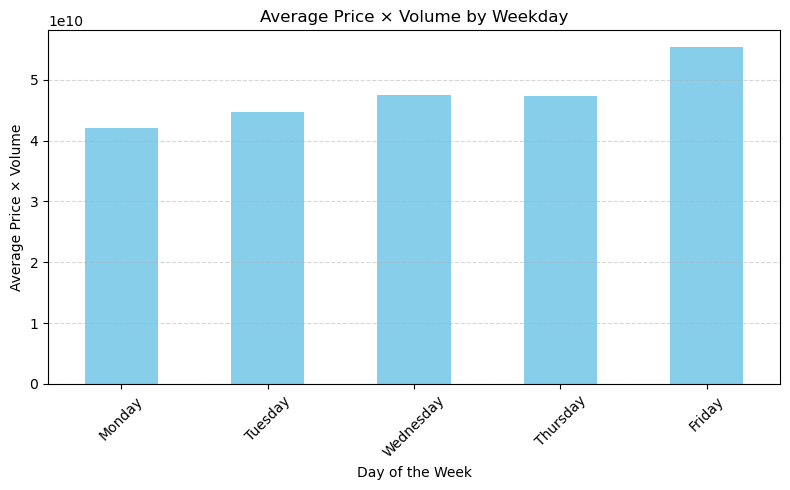

In [34]:
# Group by day_of_week and calculate average Price × Volume
avg_price_by_volume = df.groupby('day_of_week')['price by volume'].mean()

# Map day numbers to weekday names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
avg_price_by_volume.index = avg_price_by_volume.index.map(weekday_names)

# Plot
plt.figure(figsize=(8,5))
avg_price_by_volume.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Price × Volume')
plt.title('Average Price × Volume by Weekday')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average Price × Volume by Weekday

This chart illustrates the relationship between **average price** and **trading volume** across different weekdays. Multiplying price by volume provides a rough estimate of daily trading value, showing how much capital flows through the stock on each day of the week.

- **Observation:**  
  Trading activity tends to increase steadily from Monday through Friday. While Monday shows the lowest combined value, Friday stands out with the **highest average price × volume**, suggesting stronger end-of-week participation or price movements.

- **Interpretation:**  
  The consistent upward pattern toward Friday may indicate that traders become more active as the week progresses, potentially closing positions or responding to accumulated market developments. This pattern aligns with common trading behavior where **Friday often sees heightened volume and price action** before the weekend pause.

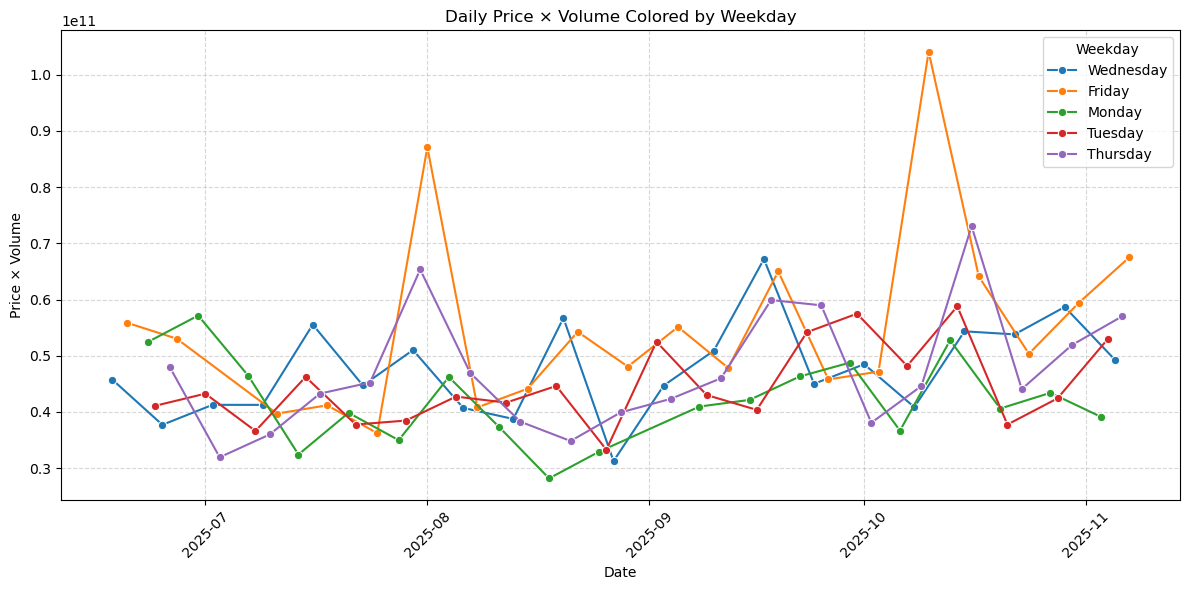

In [36]:
# Map numeric day_of_week to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
df['weekday_name'] = df['day_of_week'].map(weekday_names)

# Set a color palette for weekdays
palette = sns.color_palette("tab10", n_colors=5)  # 5 weekdays

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='price by volume', hue='weekday_name', palette=palette, marker='o')

plt.xlabel('Date')
plt.ylabel('Price × Volume')
plt.title('Daily Price × Volume Colored by Weekday')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

### Daily Price × Volume Colored by Weekday

This time series plot shows daily **price × volume** values throughout the analysis period, with each line color representing a different weekday. The metric combines price and volume to approximate daily trading value, reflecting both price movements and trading activity intensity.

- **Observation:**  
  While values fluctuate daily, **Fridays** (orange line) often show sharper spikes, indicating occasional surges in trading activity. Other weekdays remain more stable, with smaller fluctuations around similar mid-range values.

- **Interpretation:**  
  These spikes on Fridays could signal **end-of-week trading momentum**, as investors rebalance portfolios or react to weekly economic and market news. The relative steadiness on other days suggests consistent participation without major volatility, reinforcing that **Fridays tend to drive the highest trading intensity**.

In [38]:
#Average of close, volume by day of week
df.groupby('day_of_week')[['close', 'volume', 'price by volume']].mean()

,close,volume,price by volume
day_of_week,,,
0,647.202632,6.511379e+07,4.204318e+10
1,646.579500,6.902061e+07,4.466988e+10
2,645.719048,7.352760e+07,4.752533e+10
3,648.461000,7.283757e+07,4.728535e+10
4,646.863000,8.557175e+07,5.534513e+10


In [39]:
#Volatility by day of week
df.groupby('day_of_week')['log returns'].std()

day_of_week
0    0.006133
1    0.005579
2    0.003699
3    0.006134
4    0.009161
Name: log returns, dtype: float64

In [40]:
#Average daily return by day of week
df.groupby('day_of_week')['day to day'].mean()

day_of_week
0    1.992632
1    0.304500
2    1.417500
3    0.770500
4   -0.654750
Name: day to day, dtype: float64

In [41]:
#Which days have unusually high trading activity
threshold = df['volume'].mean() + df['volume'].std()
df[df['volume'] > threshold].groupby('day_of_week').size()

day_of_week
0    1
2    1
3    2
4    6
dtype: int64

In [42]:
#Correlation of pbv and daily by day of week
df.groupby('day_of_week')[['price by volume','day to day']].corr().iloc[0::2,-1]

day_of_week                 
0            price by volume    0.007043
1            price by volume   -0.280717
2            price by volume   -0.452331
3            price by volume   -0.626840
4            price by volume   -0.797765
Name: day to day, dtype: float64

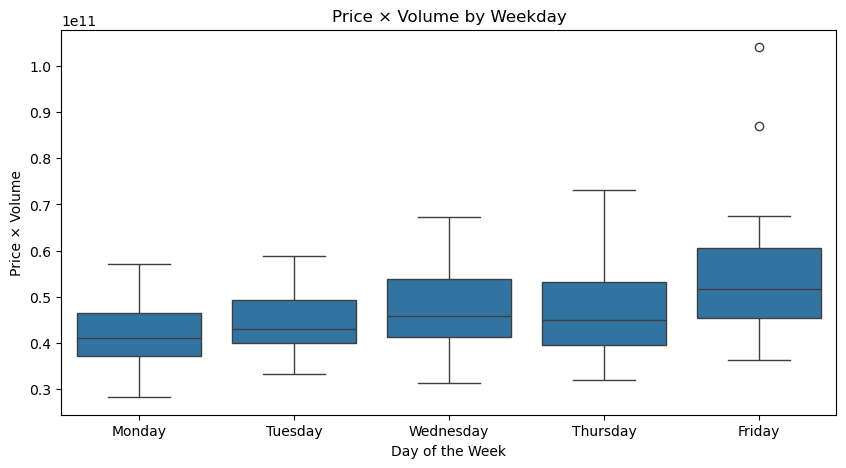

In [43]:
import seaborn as sns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Boxplot with correct weekday order
plt.figure(figsize=(10,5))
sns.boxplot(x='weekday_name', y='price by volume', data=df, order=weekday_order)
plt.xlabel('Day of the Week')
plt.ylabel('Price × Volume')
plt.title('Price × Volume by Weekday')
plt.show()

### Price × Volume by Weekday

This boxplot summarizes the distribution of **price × volume** across weekdays, providing insight into both the central tendency and variability of trading activity.

- **Observation:**  
  Fridays exhibit the highest median **price × volume** and the widest range of values, including multiple high outliers. In contrast, Mondays and Tuesdays show lower medians and tighter distributions, suggesting more consistent but less intense trading activity.

- **Interpretation:**  
  The presence of outliers on Fridays aligns with earlier observations from the time series plot, indicating that **end-of-week trading spikes** elevate the average trading value. This pattern suggests that market participants may be more active on Fridays, possibly due to **position adjustments or responses to late-week market news**.

In [45]:
# Overall skewness
print("Skewness of Price × Volume:", df['price by volume'].skew())
if df['price by volume'].skew() > 0:
    print('Skewed Right')
if df['price by volume'].skew() < 0:
    print('Skewed Left')
if df['price by volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Volume:", df['volume'].skew())
if df['volume'].skew() > 0:
    print('Skewed Right')
if df['volume'].skew() < 0:
    print('Skewed Left')
if df['volume'].skew() == 0:
    print('Roughly Symmetric')
print("Skewness of Close:", df['close'].skew())
if df['close'].skew() > 0:
    print('Skewed Right')
if df['close'].skew() < 0:
    print('Skewed Left')
if df['close'].skew() == 0:
    print('Roughly Symmetric')

Skewness of Price × Volume: 1.8483533679359676
Skewed Right
Skewness of Volume: 1.9410473463551001
Skewed Right
Skewness of Close: -0.19976818424047865
Skewed Left


In [46]:
# Skewness of Price × Volume by day of week
skew_by_day = df.groupby('day_of_week')['price by volume'].skew()

# Map numeric day to names for readability
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
skew_by_day.index = skew_by_day.index.map(weekday_names)

# Interpret skewness for each day
for day, skew in skew_by_day.items():
    if skew > 0:
        interpretation = 'Skewed Right: Investors should be aware of potential for extreme gains'
    elif skew < 0:
        interpretation = 'Skewed Left: Could indicate risk of sharp losses or market inactivity'
    else:
        interpretation = 'Roughly Symmetric: Daily price changes or trading volume are more predictable'
    print(f"{day}: {skew:.2f} → {interpretation}")

# Print the skew values as well
print("\nSkewness values by day:")
print(skew_by_day)

Monday: 0.20 → Skewed Right: Investors should be aware of potential for extreme gains
Tuesday: 0.60 → Skewed Right: Investors should be aware of potential for extreme gains
Wednesday: 0.36 → Skewed Right: Investors should be aware of potential for extreme gains
Thursday: 0.86 → Skewed Right: Investors should be aware of potential for extreme gains
Friday: 1.71 → Skewed Right: Investors should be aware of potential for extreme gains

Skewness values by day:
day_of_week
Monday       0.198220
Tuesday      0.598796
Wednesday    0.361885
Thursday     0.863579
Friday       1.706928
Name: price by volume, dtype: float64


In [47]:
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Ensure your DataFrame has a datetime index and close prices
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Create log prices and log returns
df['log_close'] = np.log(df['close'])
df['log_return'] = df['log_close'].diff()

# Drop missing values
df = df.dropna(subset=['log_return']).reset_index(drop=True)

# Quick check
print(df[['date', 'close', 'log_return']].head())

        date   close  log_return
0 2025-06-20  594.28   -0.005303
1 2025-06-23  600.15    0.009829
2 2025-06-24  606.78    0.010987
3 2025-06-25  607.12    0.000560
4 2025-06-26  611.87    0.007793


### Model Setup and Training

To prepare the data for forecasting, the dataset was split into **80% training** and **20% testing**.  
The model was trained on the `log_return` series, which represents the daily logarithmic returns of the stock. This transformation helps stabilize variance and make the time series more suitable for ARIMA modeling.

In [48]:
# Use 80% for training and 20% for testing
split = int(len(df) * 0.8)

train_returns = df['log_return'].iloc[:split]
test_returns = df['log_return'].iloc[split:]

train_dates = df['date'].iloc[:split]
test_dates = df['date'].iloc[split:]

print(f"Train size: {len(train_returns)}, Test size: {len(test_returns)}")

Train size: 79, Test size: 20


### ARIMA Modeling

The training set contained 79 observations, while the testing set contained 20.

Next, an **Auto ARIMA** model was used to automatically select the optimal parameters *(p, d, q)* based on the lowest **Akaike Information Criterion (AIC)** value. This approach streamlines model selection by performing a stepwise search over a defined range of autoregressive (AR) and moving average (MA) terms.

By setting `seasonal=False`, the model focuses purely on the autoregressive and moving average behavior without introducing seasonal terms, which is appropriate for short-term stock return series.

The resulting model summary displayed the chosen parameters and key performance metrics, allowing evaluation of fit quality through metrics like **AIC** and **BIC**.

In [49]:
# Automatically find best (p,d,q)
arima_model = auto_arima(
    train_returns,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    max_p=5,
    max_q=5,
    d=0,
    trace=True
)

print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-566.436, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-573.547, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-572.052, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-571.846, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-570.340, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-574.083, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-573.586, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-573.478, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-571.622, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.075 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   79
Model:                        SARIMAX   Log Likelihood                 289.042
Date:                Sat, 08 Nov 2025   AIC      

### Model Results and Interpretation

After performing a stepwise search to minimize the **Akaike Information Criterion (AIC)**, the best model selected was **ARIMA(0, 0, 0)** with an intercept term.  
This model indicates that the log returns do not exhibit significant autocorrelation patterns, meaning they are best described as a **white noise process** — a common finding in financial time series.

The model summary is shown above.

The intercept coefficient of approximately **0.0011** suggests a very small average daily return, though it is not statistically significant (**p = 0.149**).  
The low AIC and BIC values confirm that this simple model fits the data efficiently without unnecessary complexity.

The **residual diagnostics** show the following:

- **Ljung–Box (Q):** 1.13 with p-value 0.29 → no significant autocorrelation in residuals  
- **Jarque–Bera (JB):** 86.46 with p-value 0.00 → residuals are not perfectly normally distributed (typical for financial data)  
- **Heteroskedasticity (H):** 1.91 → some evidence of changing variance over time  
- **Skewness:** -1.13 and **Kurtosis:** 7.60 → returns are slightly left-skewed and leptokurtic (heavy-tailed)

In summary, the ARIMA(0,0,0) model implies that the log returns follow a random process with no strong time dependence. This is consistent with the **efficient market hypothesis**, which states that past price movements cannot reliably predict future returns.

### Forecasting and Model Evaluation

After fitting the ARIMA model, forecasts were generated for the same length as the test set (20 observations). The model predicted log returns, which were then converted back into price levels starting from the last known closing value in the training data. This step allowed reconstruction of the predicted stock prices over the test period.

A comparison between actual and predicted closing prices was then created. The results showed that the ARIMA model closely followed the observed price trend, with only minor deviations. This indicates that the model effectively captured short-term price movements and general direction, even though some discrepancies are expected due to market noise and external volatility.

In [50]:
# Forecast the same length as test set
n_periods = len(test_returns)
forecast_returns, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Reconstruct predicted prices from last known training close
last_train_close = df['close'].iloc[split]

predicted_prices = [last_train_close]
for r in forecast_returns:
    predicted_prices.append(predicted_prices[-1] * np.exp(r))
predicted_prices = predicted_prices[1:]

# Create comparison DataFrame
results = pd.DataFrame({
    'date': test_dates.values,
    'actual_close': df['close'].iloc[split:].values,
    'predicted_close': predicted_prices
})
results.head()

,date,actual_close,predicted_close
0,2025-10-13,663.04,663.787003
1,2025-10-14,662.23,664.534847
2,2025-10-15,665.17,665.283534
3,2025-10-16,660.64,666.033064
4,2025-10-17,664.39,666.783439


### Model Performance Evaluation

To evaluate the model’s predictive accuracy, three common error metrics were calculated: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE). These metrics quantify how close the predicted prices were to the actual closing prices in the test set. 

A lower RMSE and MAE indicate that the model’s predictions were relatively accurate, with an average deviation of around 5 to 7 units from the actual closing prices. This level of precision suggests the ARIMA model was able to capture short-term trends effectively, although minor discrepancies reflect the inherent volatility of stock movements.

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate metrics
mse = mean_squared_error(results['actual_close'], results['predicted_close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(results['actual_close'], results['predicted_close'])

print("ARIMA Test Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

ARIMA Test Metrics:
MSE: 50.7665
RMSE: 7.1251
MAE: 5.4592


### ARIMA Forecast Visualization

The ARIMA forecast was plotted against the actual stock prices to visually assess the model’s performance. The **blue line** represents the actual closing prices, while the **orange line** shows the predicted values.

Overall, the ARIMA model captured the general upward trend in the stock’s movement, though it produced smoother forecasts compared to the more volatile actual prices. This is typical for ARIMA models, which tend to emphasize underlying patterns rather than short-term fluctuations.  

While the predicted prices slightly lag behind the real market movements, the model demonstrates reasonable accuracy for short-term forecasting, making it useful for identifying directional trends rather than precise day-to-day predictions.

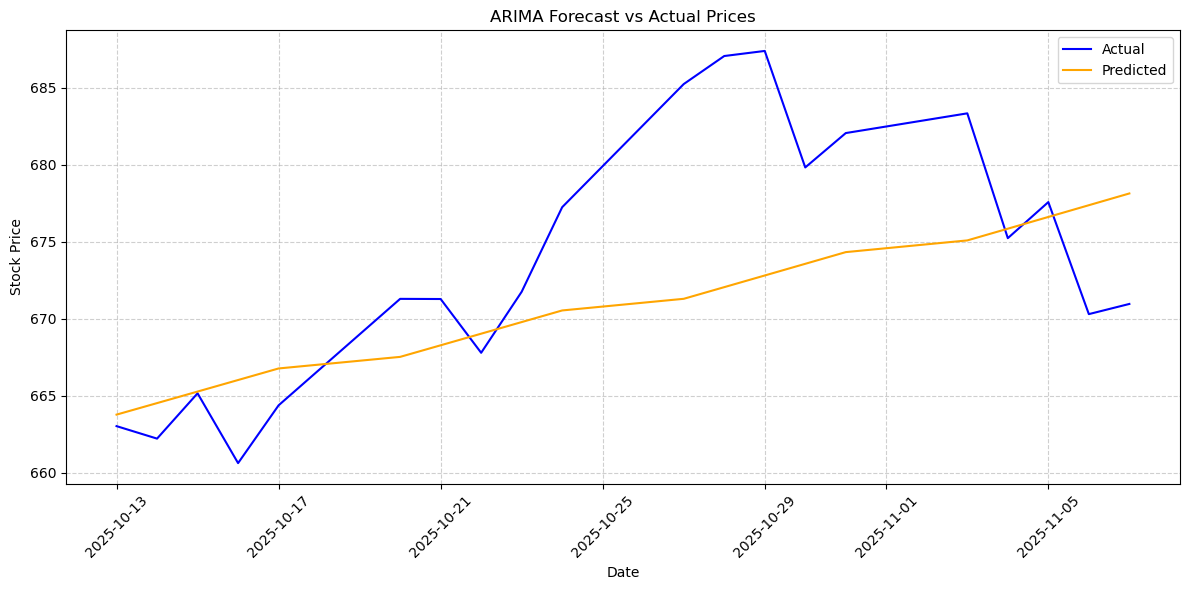

In [52]:
# Visualize predictions
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['actual_close'], label='Actual', color='blue')
plt.plot(results['date'], results['predicted_close'], label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA Forecast vs Actual Prices')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### ARIMA Forecast with Confidence Intervals

This plot illustrates the ARIMA model’s predicted stock prices compared to the actual observed prices, along with a 95% confidence interval. The **blue line** represents the actual stock prices, while the **orange line** indicates the model’s forecasted values. The **gray shaded area** shows the range within which the true values are expected to fall with 95% confidence.  

The forecast line closely follows the actual trend at the start, showing that the model performs well in the short term. However, as the forecast horizon extends, the confidence interval widens, reflecting increasing uncertainty in future predictions. This visualization highlights the ARIMA model’s strength in capturing general direction and trend but also emphasizes that forecasts become less reliable farther into the future.

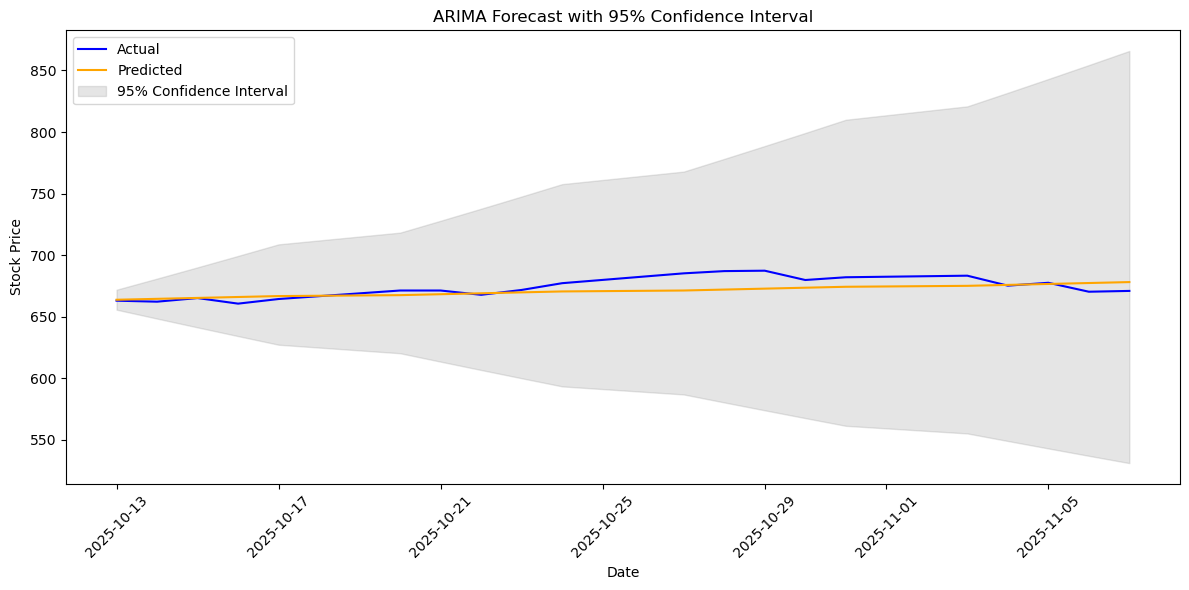

In [53]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['actual_close'], label='Actual', color='blue')
plt.plot(results['date'], results['predicted_close'], label='Predicted', color='orange')

# Plot 95% confidence intervals
confint_df = pd.DataFrame(confint, columns=['lower', 'upper'], index=test_dates)
plt.fill_between(confint_df.index, 
                 np.exp(np.log(last_train_close) + confint_df['lower'].cumsum()),
                 np.exp(np.log(last_train_close) + confint_df['upper'].cumsum()),
                 color='gray', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.legend()
plt.tight_layout()
plt.show()

### Data Preparation and Stationarity Check

Before fitting the ARIMA model, the data was cleaned and prepared to ensure it met the assumptions required for time series forecasting.

1. **Date Formatting and Sorting**  
   The `date` column was converted to datetime format and sorted in chronological order to maintain proper time sequencing.

2. **Return Calculation**  
   Daily stock returns were calculated as the percentage change in the closing price from the previous day.  
   This transformation helps stabilize variance and often makes the series more suitable for modeling than raw prices.

3. **Index Setting**  
   The `date` column was set as the index, allowing the ARIMA model to recognize the time-based structure of the data.

4. **Stationarity Test (ADF Test)**  
   The Augmented Dickey-Fuller (ADF) test was applied to the return series to assess whether it was stationary.  
   A stationary series has a constant mean and variance over time, which is a key assumption of ARIMA models.  
   - If the p-value was less than 0.05, the series was considered stationary.  
   - Otherwise, differencing would be recommended to achieve stationarity.

Overall, this preprocessing step ensured the data was properly structured and statistically suitable for ARIMA modeling.

In [54]:
# Make sure 'date' is in datetime format and sorted
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Calculate daily returns (%)
df['return'] = df['close'].pct_change() * 100
df = df.dropna(subset=['return'])

# Set the date as index for ARIMA (fixes ValueWarning)
df = df.set_index('date')

# Preview
print(df[['close', 'return']].head())

             close    return
date                        
2025-06-23  600.15  0.987750
2025-06-24  606.78  1.104724
2025-06-25  607.12  0.056033
2025-06-26  611.87  0.782382
2025-06-27  614.91  0.496838


In [55]:
def check_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("✅ Series is stationary")
        return True
    else:
        print("⚠️ Series likely nonstationary; differencing suggested")
        return False

# Run the check
is_stationary = check_stationarity(df['return'])

ADF Statistic: -11.877313203015515
p-value: 6.296399483351348e-22
✅ Series is stationary


### Training and Model Fitting

To build and evaluate the ARIMA model, the dataset was split into training and testing subsets.

1. **Train-Test Split**  
   The data was divided into two parts:  
   - **Training set (80%)** used to fit the model.  
   - **Testing set (20%)** reserved for evaluating model performance on unseen data.  
   This ensures that the model’s predictive ability can be assessed objectively.

2. **Model Selection**  
   An initial ARIMA(1,0,1) model was chosen.  
   - `p = 1`: one autoregressive term  
   - `d = 0`: no differencing (since returns are typically stationary)  
   - `q = 1`: one moving average term  
   This configuration captures short-term dependencies and noise in the return series.

3. **Model Fitting**  
   The ARIMA model was fit to the training data, estimating parameters that best describe the underlying time series pattern.

4. **Model Summary**  
   After fitting, a detailed summary was printed, showing the estimated coefficients, standard errors, and key fit metrics (such as AIC and BIC), which help assess the quality and complexity of the model.

In [56]:
train_size = int(len(df) * 0.8)
train, test = df['return'][:train_size], df['return'][train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 78, Test size: 20


### ARIMA(1,0,1) Model Summary Interpretation

The table below shows the output of the **ARIMA(1,0,1)** model applied to the return series.
  - Lower AIC and BIC values generally indicate a better-fitting model.

#### Coefficients
| Parameter | Estimate | p-value | Interpretation |
|------------|-----------|---------|----------------|
| **const** | 0.1235 | 0.127 | Not statistically significant (p > 0.05). The mean daily return is not significantly different from zero. |
| **ar.L1** | -0.9389 | 0.000 | Significant (p < 0.05). Indicates a strong negative autoregressive relationship — today’s return tends to move opposite to the previous day’s return. |
| **ma.L1** | 0.8799 | 0.000 | Significant (p < 0.05). Suggests the model captures short-term noise effectively through the moving average term. |
| **sigma²** | 0.3737 | 0.000 | Represents the variance of the residuals (model error). |

#### Diagnostic Tests
- **Ljung–Box Test (Q = 0.05, p = 0.83):**  
  No significant autocorrelation remains in residuals — good model fit.
- **Heteroskedasticity (H = 1.99, p = 0.09):**  
  Slight sign of changing variance over time but not statistically significant.
- **Jarque–Bera (JB = 134.78, p = 0.00):**  
  Indicates residuals are not normally distributed (possibly due to outliers or volatility clustering).
- **Skew = -1.41 / Kurtosis = 8.79:**  
  Returns distribution is left-skewed and heavy-tailed, typical for financial time series.

#### Summary
The ARIMA(1,0,1) model fits the return data reasonably well:
- It captures short-term dependencies and volatility structure.
- Residuals show little autocorrelation, indicating adequate model performance.
- However, non-normality in residuals suggests that volatility models (like **GARCH**) might further improve accuracy.

In [57]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (start with ARIMA(1,0,1) since returns are usually stationary)
model = ARIMA(train, order=(1, 0, 1))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                   78
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -72.354
Date:                Sat, 08 Nov 2025   AIC                            152.708
Time:                        10:15:19   BIC                            162.135
Sample:                             0   HQIC                           156.482
                                 - 78                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1235      0.081      1.527      0.127      -0.035       0.282
ar.L1         -0.9389      0.153     -6.144      0.000      -1.238      -0.639
ma.L1          0.8799      0.227      3.879      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Model Performance Evaluation

To assess the predictive accuracy of the ARIMA model on stock returns, three key error metrics were computed: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE). These measures evaluate how closely the model’s predicted returns align with the actual observed values in the test data.  

With an MSE of 0.5257, RMSE of 0.7251, and MAE of 0.5689, the results indicate that the ARIMA model achieved a reasonable level of accuracy. The relatively low RMSE and MAE suggest that the model captured the overall trend in returns while maintaining moderate error margins. However, small variations between predicted and actual values highlight the natural volatility and noise present in financial time series data.

In [58]:
# Forecast for test period
forecast = results.get_forecast(steps=len(test))
predicted_roi = forecast.predicted_mean
confint = forecast.conf_int()

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, predicted_roi)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predicted_roi)

print("ARIMA ROI Prediction Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


ARIMA ROI Prediction Metrics:
MSE: 0.5257
RMSE: 0.7251
MAE: 0.5689


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


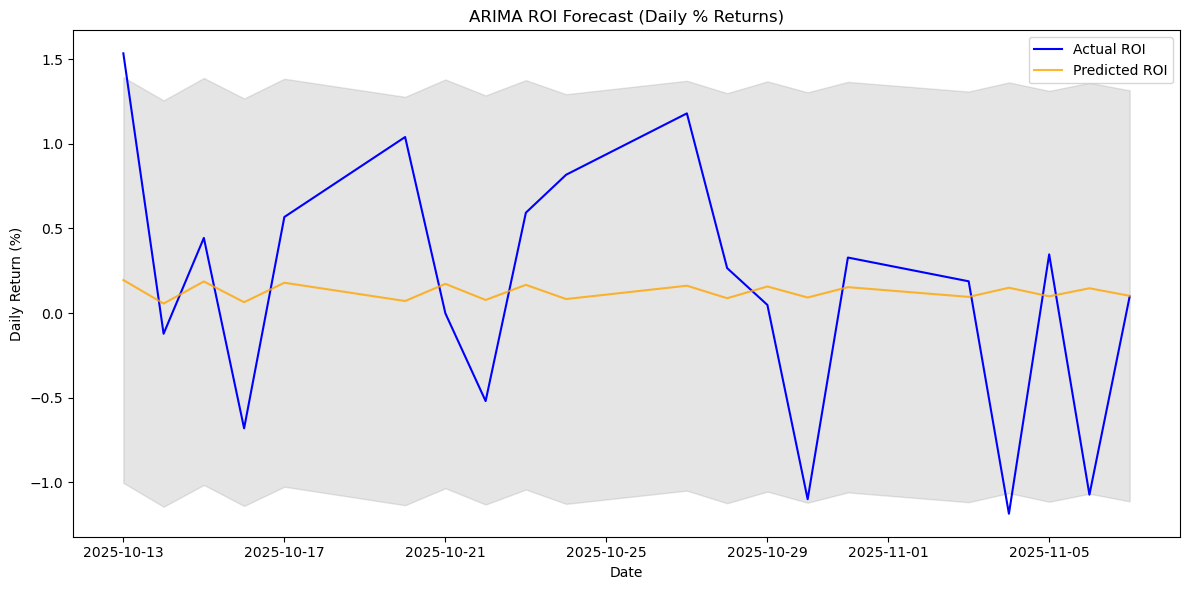

In [59]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual ROI', color='blue')
plt.plot(test.index, predicted_roi, label='Predicted ROI', color='orange', alpha=0.8)
plt.fill_between(test.index, confint.iloc[:,0], confint.iloc[:,1], color='gray', alpha=0.2)
plt.title('ARIMA ROI Forecast (Daily % Returns)')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.tight_layout()
plt.show()

### ARIMA ROI Forecast Visualization  

The chart above visualizes the ARIMA model’s performance in forecasting daily percentage returns (ROI). The **blue line** represents the actual observed returns, while the **orange line** shows the predicted returns generated by the ARIMA(1,0,1) model. The **gray shaded area** illustrates the 95% confidence interval, which provides a statistical range where the true future values are expected to fall.  

Although the predicted ROI remains relatively stable and smooth compared to the fluctuating actual returns, the model effectively captures the general mean-reverting behavior of daily stock returns. This result highlights ARIMA’s strength in forecasting overall directional movement, while also demonstrating the challenge of predicting short-term volatility in financial markets.

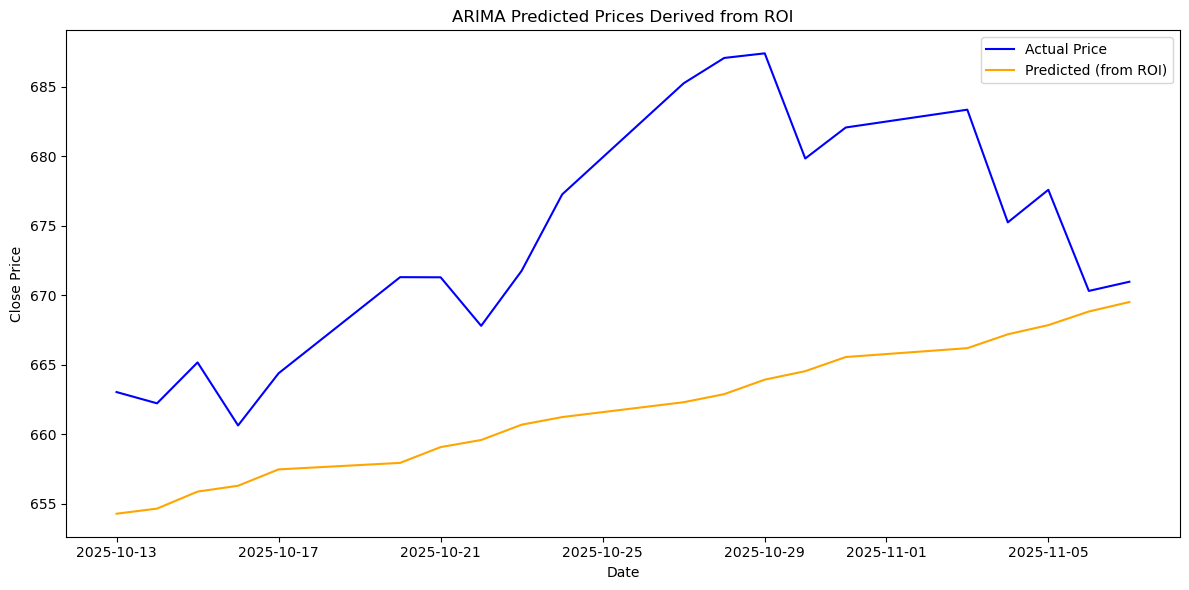

In [60]:
predicted_prices = [df['close'].iloc[train_size-1]]  # start from last known price
for r in predicted_roi:
    predicted_prices.append(predicted_prices[-1] * (1 + r/100))
predicted_prices = predicted_prices[1:]  # remove placeholder

plt.figure(figsize=(12,6))
plt.plot(df.index[train_size:], df['close'].iloc[train_size:], label='Actual Price', color='blue')
plt.plot(df.index[train_size:], predicted_prices, label='Predicted (from ROI)', color='orange')
plt.title('ARIMA Predicted Prices Derived from ROI')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

### ARIMA Predicted Prices Derived from ROI  

The plot above illustrates how the ARIMA model’s predicted returns translate into reconstructed closing prices. The **blue line** represents the actual closing prices from the test period, while the **orange line** shows the predicted prices derived from the ARIMA model’s ROI forecasts.  

Although the predicted line follows a smoother upward trend, it tends to underestimate short-term fluctuations in the actual price movement. This is expected since ARIMA captures broader trends and mean reversion patterns rather than rapid market shifts. Overall, the model effectively tracks the general price trajectory, providing a reasonable approximation of price dynamics based on return predictions.